In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import functorch

from omegaconf import OmegaConf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from pyhessian.hessian import hessian # Hessian computation
from pyhessian.density_plot import get_esd_plot # ESD plot
from pyhessian.utils import hessian_vector_product # Hessian-vector product
from plot_utils import *

In [3]:
args = OmegaConf.create(
    dict(
        learning_rate = 1e-3,
        batch_size = 64,
        epochs = 100
    )
)

In [4]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=args.batch_size)
test_dataloader = DataLoader(test_data, batch_size=args.batch_size)

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(28*28, 16),
            nn.Sigmoid(),
            nn.Linear(16, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_sigmoid_stack(x)
        return logits

model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate)

num_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {num_params}')

Total number of parameters: 12730


In [6]:
# device to use for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # print
        if batch % 100 == 0:
            loss, current = loss.item(), batch*args.batch_size+len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Hessian ESD and Top Eigenvalue before training

In [8]:
hessian_dataloader = DataLoader(training_data, batch_size=training_data.data.shape[0])
for inputs, targets in hessian_dataloader:
    break
inputs, targets = inputs.to(device), targets.to(device)

/home/nadezhda/anaconda3/envs/semester_project/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /croot/pytorch-select_1725478810240/work/torch/csrc/autograd/engine.cpp:1203.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/nadezhda/Desktop/spectral-properties-of-NN/pyhessian/density_plot.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


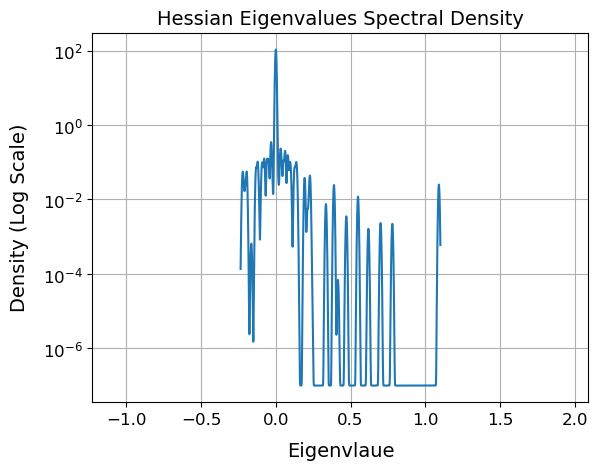

In [9]:
hessian_comp = hessian(model, loss_fn, data=(inputs, targets), cuda=torch.cuda.is_available())
density_eigen, density_weight = hessian_comp.density()
get_esd_plot(density_eigen, density_weight)

In [10]:
# print the top eigenvalue
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
print("Top eigenvalue:", top_eigenvalues[0])

Top eigenvalue: 1.0877991914749146


### Training

In [11]:
for t in range(args.epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.371809  [   64/60000]
loss: 2.361044  [ 6464/60000]
loss: 2.421033  [12864/60000]
loss: 2.397392  [19264/60000]
loss: 2.368022  [25664/60000]
loss: 2.304002  [32064/60000]
loss: 2.274926  [38464/60000]
loss: 2.336049  [44864/60000]
loss: 2.314520  [51264/60000]
loss: 2.343526  [57664/60000]
Test Error: 
 Accuracy: 9.6%, Avg loss: 2.304837 

Epoch 2
-------------------------------
loss: 2.291967  [   64/60000]
loss: 2.288718  [ 6464/60000]
loss: 2.344335  [12864/60000]
loss: 2.310397  [19264/60000]
loss: 2.306435  [25664/60000]
loss: 2.267440  [32064/60000]
loss: 2.245839  [38464/60000]
loss: 2.298889  [44864/60000]
loss: 2.274971  [51264/60000]
loss: 2.287391  [57664/60000]
Test Error: 
 Accuracy: 17.9%, Avg loss: 2.267448 

Epoch 3
-------------------------------
loss: 2.253608  [   64/60000]
loss: 2.252945  [ 6464/60000]
loss: 2.301047  [12864/60000]
loss: 2.261364  [19264/60000]
loss: 2.268608  [25664/60000]
loss: 2.243537  [32064/6000

### Hessian ESD and Top Eigenvalue after training

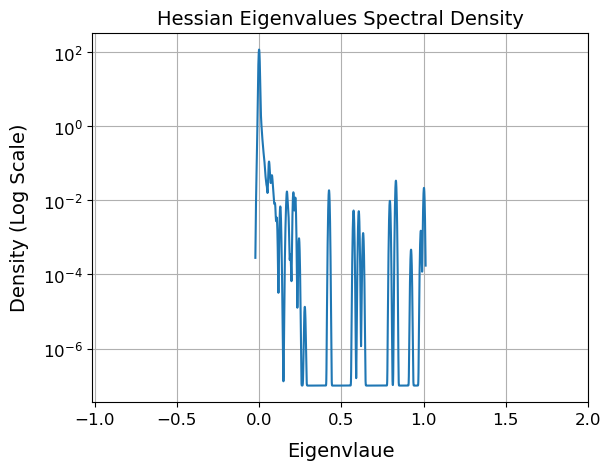

In [12]:
hessian_comp = hessian(model, loss_fn, data=(inputs, targets), cuda=torch.cuda.is_available())
density_eigen, density_weight = hessian_comp.density()
get_esd_plot(density_eigen, density_weight)

In [13]:
# print the top eigenvalue
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
print("Top eigenvalue:", top_eigenvalues[0])

Top eigenvalue: 0.9815375208854675


### Compute Hessian using HVPs

In [14]:
hessian_hvp = np.zeros((num_params, num_params))
for i in tqdm(range(num_params)):
    v = [torch.zeros(p.size()).to(device) for p in hessian_comp.params]
    # flatten the vector and set the i-th element to 1
    flattened_v = torch.zeros(num_params).to(device)
    flattened_v[i] = 1
    # reshape the vector back to the original shape
    reshaped_v = []
    start = 0
    for t in v:
        numel = t.numel()  # get the number of elements in the current tensor
        reshaped_v.append(flattened_v[start:start + numel].view_as(t))  # reshape the chunk back
        start += numel
    # compute the Hessian-vector product
    hvp = hessian_vector_product(hessian_comp.gradsH, hessian_comp.params, reshaped_v)
    hvp_flat = torch.cat([t.flatten() for t in hvp])
    hessian_hvp[i] = hvp_flat.cpu().detach().numpy()
hessian_hvp = hessian_hvp.T
np.save('results/hessian_hvp.npy', hessian_hvp)
# hessian_hvp = np.load('results/hessian_hvp.npy')

100%|██████████| 12730/12730 [06:53<00:00, 30.77it/s]


In [15]:
# compute the eigenvalues of the Hessian
eigenvalues_hvp, eigenvectors_hvp = np.linalg.eigh(hessian_hvp)
np.save('results/eigenvalues_hvp.npy', eigenvalues_hvp)
# eigenvalues_hvp = np.load('results/eigenvalues_hvp.npy')

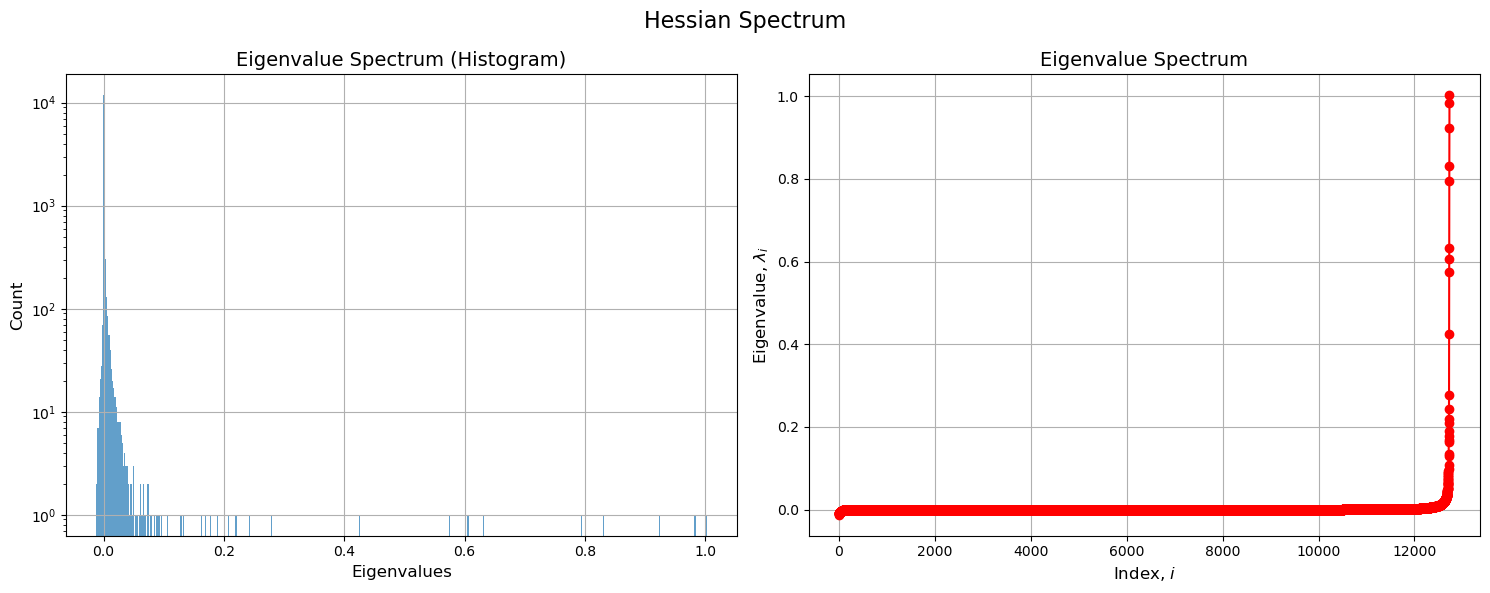

In [16]:
plot_spectrum_combined(eigenvalues_hvp, 500, "Hessian Spectrum")

#### Visualization

In [17]:
hessian_hvp = np.load('results/hessian_hvp.npy')
print("Maximal value in the Hessian matrix:", np.max(hessian_hvp))
print("Minimal value in the Hessian matrix:", np.min(hessian_hvp))
print("Percentage of values equal to zero:", np.sum(hessian_hvp == 0) / hessian_hvp.size)
print("Percentage of values in [-0.015, 0.015]:", np.sum(np.abs(hessian_hvp) < 0.015) / hessian_hvp.size)

Maximal value in the Hessian matrix: 0.05886616185307503
Minimal value in the Hessian matrix: -0.02307216264307499
Percentage of values equal to zero: 0.36887786642509945
Percentage of values in [-0.015, 0.015]: 0.9999940081294442


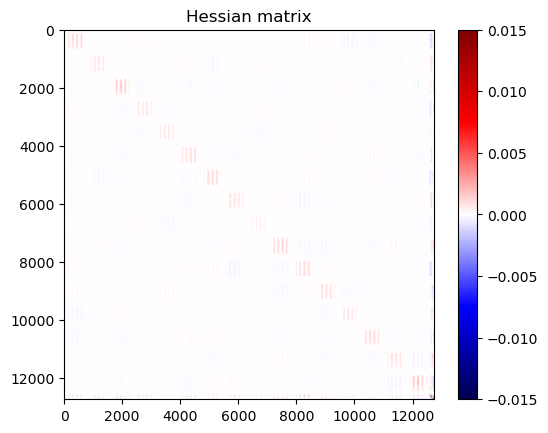

In [18]:
plt.imshow(hessian_hvp, vmin=-0.015, vmax=0.015, cmap='seismic')
plt.colorbar()
plt.title('Hessian matrix')
plt.show()